# Machine learning в продакшне

Поговорим, от том, как выводить модели в продакшн. Вы уже знакомы с понятием "жизненный цикл ML проекта" - сегодня мы увидим, как этот цикл выглядит в реальной жизни и попробуем вывести в продакшн модель классификации с помощью технологии виртуализации Docker (можно и без docker)

In [2]:
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)[:5]))

Содержимое директории /opt/ml/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


В этом уроке мы поговорим о том, как обосновать перед бизнесом необходимость внедрения новой ML-системы

## Оффлайн эксперимент. Proof concept

В рамках курса вы
* узнали про огромное количество моделей: классификация, регрессия
* научились оценивать качество моделей
* можете готовить данные для алгоритмов, включая генерацию фичей

Однако, бизнесу не интересны задачи классификации или регрессии - бизнесу интересно зарабатывать деньги. Чтобы заработать деньги с помощью ML нужно найти конкретную бизнес-проблему, поиском проблем в бизнесе должен заниматься владелец бизнеса (в методологии Agile его зовут Product Owner) и понять, как эту бизнес-проблему можно решить. После такого  начального этапа выявления проблемы бизнес-хотелка отдаётся ML-специалисту, который должен создать инженерное решение для проблемы и интергрировать его в продакшн - после выкатывания прототипа "в прод" бизнес начинает зарабатывать миллионы и все счастливы.

Ниже я приведу полный путь от бизнес-идеи до прототипа - такой путь проходит любой проект ML, а называют такой пайплайн Proof of concept:

1. Перейти от общих слов продукт оунера к конкретным бизнес-требованиям. Желательно, чтобы DS проводил её сам (возможно привлечь бизнес-аналитика).
1. Описать дизайн (схему) эксперимента. Нужно понять, как повлиять на бизнес-метрики из первого пункта. На этом этапе нужно понять, какая информация доступна на входе, что ожидается на выходе и к какой задаче ML это можно свести  какие метрики покажут успешность задачи
1. Разобраться с данными: где храняться достаточно ли их для проверки гипотезы. Неплохо бы сразу осознать, будут ли данные в продакшене отличаться от того, что доступно в трейне.
1. Наинженерить фич и построить модель
1. Оценить качество модели, посчитать технические и бизнесовые метрики (см. третий урок)
1. Оценить ROI (Return on Investment) — ради этого всё и затевается.

Фишка этих шагов в том, что ошибка на любом шаге сильно ухудшает весь проект - например, плохая постановка бизнес-требований приведёт к провальному эксперименту.

Расчёт ROI - самый важный, финальный этап. Без расчёта эффективности бизнес-заказчик не даст вам добра на выкатывание в продакшн.

ROI  — это показатель доходности проекта, равный отношению доходов к затраченным инвестициям. ROI < 100% означает, что проект не окупится.

`ROI` = (`LTP`)/(`CL` + `LTL`)

1. LTP(Lifetime Profit)  - сколько доходов принесёт проект, пока его не свернут. Вычисляется как *операционные доходы* $\times$ *срок жизни*
1. CL (Capital Loss) - затраты на старт проекта
1. LTL(Lifetime Loss)  - сколько расходов принесёт проект, пока его не свернут. Вычисляется как *операционные расходы проекта* $\times$ *срок жизни проекта*

В капитальные затраты входит закупка железа и лицензий, разработку системы и ее внедрение. Операционные расходы - это то, что тратится на поддержание сервиса: зарплата программистов, devops-инженеров, аренда серверов.

Из-за "мгновенных" капитальных расходов на старте проекта ROI будет зависеть от времени, на котором мы оцениваем доходность. Обычно для расчета ROI используется или год - нужно понять, окупится проект за год или нет.


На далеком горизонте планирования можно окупить любую систему, поэтому важно понять величину *Lifetime* - сколько проработает система

В этом уроке мы узнали, что такое Proof of concept: какие действия нужно произвести чтобы понять, что модель будет полезна и принесёт выгоду. В следующем уроке мы поговорим о метриках сервиса - как понять, что модель действительно работает

## Метрики моделей ML

Метрики ML-сервисов (как и любых других продакшн-систем) можено разделить на три основных группы

* оффлайн-метрики модели
* технические метрики сервиса
* продуктовые (бизнес) метрики


### Оффлайн метрики

Оффлайн-метрики показывают, насколько хорошо алгоритм "выучил" исторические данные. С этими метриками вы сталкивались в течение всего курса:

* RMSE
* MAE
* precision
* recall
* accuracy
* MAP
* $\ldots$

Эти метрики не могут сказать, что модель будет достаточно хороша для бизнеса, но такая модель, как минимум, будет "не совсем плоха" чтобы отказываться от её выкатывания в прод. То есть выкатывают модель с хорошими оффлайн метриками и надеются, что она улучшит онлайн-метрики (см. дальше)

В реальной жизни обучение модели запускается регулярно, поэтому оффлайн-метрики нуждаются в мониторинге.

Пример из боевой системы обучения моделей: если ROC-AUC падает ниже 0.8, то модель в продакшн не выкатывается, а разработчику приходит уведомление в slack: дружище, с твоей моделью что-то не так, посмотри что случилось:

```shell
12:11:52,344 | INFO     | hydramatrices_data.py    :65   | Данные из HDFS загружены
12:12:10,651 | INFO     | learn2rank_model.py      :168  | Разбили данные на train и test
12:13:15,113 | INFO     | learn2rank_model.py      :248  | Кол-во объектов в train 1643676
12:14:24,329 | INFO     | learn2rank_model.py      :265  | Новая модель Learning to Rank c2c готова
12:14:49,295 | INFO     | learn2rank_model.py      :268  | Train Area under ROC = 0.8517
12:15:11,057 | INFO     | learn2rank_model.py      :272  | Test Area under ROC = 0.8516
```

### Технические метрики

Технические метрики сервиса - это некоторые показатели "здоровья", железа, которые никак не связаны с логикой

* `RPS` (response per second) - сколько запросов в секунду прилетает на сервис
* `response time` - время ответа сервиса
* `CPU idle` - "бездействие системы", чем больше тем лучше. Если падает idle - значит, сильно загружен процессор
* `available memory` - сколько памяти доступно на серверах
* `500 errors` - количество 500-х ошибок на сервисе

Дэшборды с техническими метриками могут выглядеть как-то так:

![tech_metrics](img/tech_metrics.png)

Для сбора и визуализации технических метрик используются следующие инструменты, которые должен знать каждый ML специалист:

* statsd - хранение метрик
* Grafana - визуализиция графиков
* Zabbix - визуализация и отправка уведомлений (например, в slack)
* Sentry - для анализа 500-х ошибок
* Kibana - логи сервиса

Прежде чем катить модель в прод нужно ознакомиться с каждым из этих инструментов и интегрировать с ними свою модель.

### Продуктовые метрики

Продуктовые метрики это то, что в первую очередь интересует бизнес. Когда выкатываете новую модель - она должна делать бизнесу лучше, а делать ML ради ML точно не стоит

Какие метрики можно улучшить с помощью ML

* средний чек
* retention - возвращаемость клиентов на сервис
* churn - отток клиентов с сервиса
* bounce - % пользователей, которые зашли на сервис, но ничего не сделали  (показатель отказов)
* конверсия в покупку

Проверять, что ваша модель улучшает метрики следует с помощью АБ-теста

![ab_testing](img/ab_testing.png)

В этом уроке мы узнали, как следить за моделями в продакшн. Вы познакомились с понятием "технические метрики сервиса" и теперь знаете, как сделать из "чёрного ящика" вашей модели прозрачный и управляемый сервис

В следующем уроке мы перейдём к самому интересному - поговорим, как разворачивать модели на боевых серверах

## Деплой модели: Docker

Этапы разработки прод-сервиса:
* разведочный анализ данных
* прототип модели в Jupyter
* продакшн-сервис

Как же перейти от любимого Jupyter ноутбука к продакшин сервису? Современные архитектуры web-проектов предполагают т.н. микросервисную архитектуру, когда для решения конкретной бизнес задачи поднимается маленький веб-сервис, который умеет принимать http-запросы и делать predict, возвращая предсказания в виде json-объекта.

JSON - это стадартный формат для общения микросервисов друг с другом, о нём говорили в самом начале курса

![microservices-logical.png](img/microservices-logical.png)

Как упаковать модель в микросервис? Для этого питоновский код нужно обернуть в http-сервер, который будет "сёрвить" (обслуживать) http-запросы. Вариантов http-сервера очень много

* [Flask](https://palletsprojects.com/p/flask/)
* [aiohttp](https://aiohttp.readthedocs.io/en/stable/)
* [http.server](https://docs.python.org/3/library/http.server.html)

Такой сервис обычно имеет url, на который можно отправлять запросы в заранее определённом формате, например `https://you.service/classify?uid=999` и возвращать ответ в JSON `{'uid': 999, 'class': 1}`

При чём тут **Docker**? Докер - это система виртуализации, которая позволяет унифицировать среду разработки и среду выполнения приложения: вы пишете код, который исполняется в виртуальной машине, тестируете его - а потом на боевые сервера отправляется та же самая виртуальная машина.

Получается, что вам не нужно волноваться о том, как будет жить питоновский код в продакшне - потому что будет исполняться в той же среде, в которой вы его разрабатывали (и тестировали). Докер является де-факто стандартом в мире современных архитектур для деплоя (т.е. вывода в продакшн-среду) моделей ML.

### Простой докер-контейнер

Вы уже пользовались докером для разворачивания Postgres базы данных, но не писали своих докерфайлов. Давайте исправим этот факт и напишем простой докер-сервис!

Алгоритм упаковки сервиса в докер следующий

1. Выбрать базовый образ. Я выбрал образ `python:3.12`
1. Чтобы докер делал что-то полезное, нужно запустить внутри него программу. Программы внутри контейнера принято запускать через файл `docker-entrypoint.sh`. Для примера я создал файл [simple-entrypoint.sh](dockerfiles/api/docker-entrypoint.sh), внутри которого три сценария работы контейнера
1. Чтобы собрать контейнер, нужно описать его структуру в Dockerfile. Загляните в файл [api/Dockerfile](dockerfiles/api/Dockerfile), где описана структура нашего контейнера

Находясь в корневой директории надо запустить сборку контейнера командой
```shell
make build-api 
```

После окончания процесса сборки запустить контейнер с помощью инструкции `docker run`:
```shell
docker run api:latest hello
```

В результате должны увидеть в консоли `Hello, engineer!`.

В этом уроке мы создали простой контейнер (для понимания), который только и умеет что выводить на печать простую фразу. В следующем уроке мы упакуем в докер пайплайн для тренировки и развёртывания модели машинного обучения в виде http-сервиса.

# Упаковка модели в Docker: этап research

Перед тем, как погружаться в мир докера, создадии пайплайн обучения на python.

Начнём с загрузки данных

In [7]:
import pandas as pd
import numpy as np

df_source = pd.read_csv(os.path.join(root_data_dir, 'client_segmentation.csv'))
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head(3)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0.0
1,-0.889273,-0.537896,-1.959469,2.0
2,-0.841503,0.846665,0.727606,0.0


Это датасет, в котором три фичи `call_diff`, `sms_diff` и `traffic_diff` которые отражают относительное изменение в объёме звонков, смс и интернет-трафика соответственно по абонентам в базе телеком-оператора и несколько классов клиентов:

* класс `0` - пользователь платит много
* класс `1` - пользователь платит мало
* класс `2` - пользователь ушёл в отток (не платит ничего)

От нас требуется обучить модель классификации на три класса.

Для визуализации данных выполним понижение размерности с помощью *t-sne*

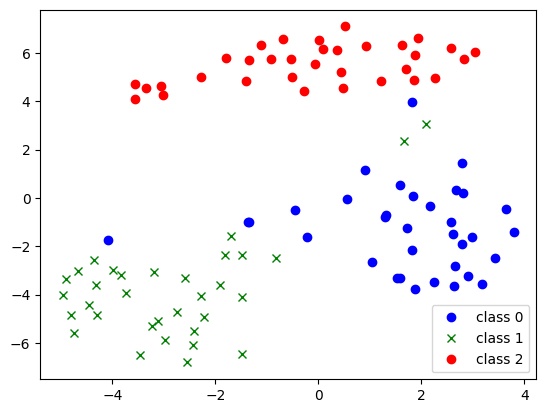

In [8]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

x_tsne = TSNE(n_components=2).fit_transform(X)
colors = ['bo', 'gx', 'ro']; num_labels = len(colors)
# И нарисуем получившиеся точки в нашем новом пространстве
for name, label, color in [('class_%d' % i, i, colors[i]) for i in range(num_labels)]:
    plt.plot(x_tsne[y == label, 0], x_tsne[y == label, 1], color, label="class %d" % label)
plt.legend(loc=0); plt.show()

Бизнесу требуется построить классификатор клиентов - давайте обучим простенький классификатор, основанный на решающем дереве.

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# выбираем рандомный объект

num_objects = X.shape[0]
random_id = np.random.randint(num_objects)

# преобразуем фичи, чтобы подошли на вход модели и делаем предсказания
test_object = X[random_id,:].reshape(1, -1)
pred = clf.predict(test_object)
print(f"У объекта под номером {random_id} класс {pred[0]}")

У объекта под номером 43 класс 0.0


Гототово, у нас есть модель, которая что-то обучает и что-то предсказывает. Можем сериализовать её для дальнейшего использования c помощью `pickle`. А теперь попробуем обернуть в докер наш пайплан обучения модели.

Запуск обучения модели - см. файл `dockerfiles/api/src/train.py`
```shell
make run-train
```

Вся полезная информация отправляется в файл с логами
```shell
tail -n1 data/pipelines-data/service.log
```

Пример логов модели
```shell
2020-04-24 06:55:54,070 | INFO     | service.py               :70   | Загружаем обученную модель
2020-04-24 06:55:54,071 | INFO     | service.py               :73   | Модель загружена: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

```

Запуск микросервиса - см. в файле `dockerfiles/api/src/main.py`
```shell
make run-service
```

Увидеть запущенный контейнер можно через Docker ps
```shell
docker ps
```

Результат команды
```shell
CONTAINER ID        IMAGE                     COMMAND                  CREATED             STATUS              PORTS                    NAMES
c9ba7303712c        mai:advanced   "docker-entrypoint.s…"   14 hours ago        Up 14 hours         0.0.0.0:5000->5000/tcp   infallible_easley
```

Чтобы проверить, что сервис "жив" и способен принимать запросы откройте в браузере спициальную страничку `http://0.0.0.0:8002/ping` - это т.н. *healh check* нашего сервиса. В браузере должно появится

```json
{"message": "pong"}
```

Хороший туториал по [упаковке моделей в контейнеры](https://towardsdatascience.com/deploying-machine-learning-models-with-docker-5d22a4dacb5). Там можно почитать, как скейлить нагрузку помощью nginx+gunikorn

В нашем датасете три фичи - нам нужно передать их в наш микросервис. Передавать фичи можно через GET-запросы, например, так:
```url
http://0.0.0.0:8001/classifier/?x1=1&x2=-2.2&x3=1.05
```

Дальше нам нужно перехватить их на стороне сервиса, обработать фичи, загрузив в классификатор и выдать ответ:
```json
{"x1": 1.0, "x2": -2.2, "x3": 1.05, "predicted_class": 0}
```

После окончания работ контейнер можно остановить
```shell
docker stop c9ba7303712c
```

Мы упаковали модель в докер и можем использовать модель как микросервис - отправлять запросы и получать предсказания

Давайте обобщим все наши знания о микросервисах в одной картинке

* у микросервиса должен быть определён формат ответа в виде JSON схемы
* Consul - это сервис, который автоматически дёргает *health check* и рестартует контейнер, если он перестал отвечать
* блок `logs` - это Elastic+Logstash+Kibana, связка используется для хранения логов
* технические метрики отправляются в хранилище Prometheus и визуализируются  в Grafana. Нотификации в случае нештатных ситуаций отправляются в Slack
* инциденты в виде 500-х ошибок отправляются в Sentry для дальнейшего анализа

![microservice.png](img/microservice.png)

# ML в проде: рекомендательные системы

Рекомендательные системы - это обобщённое название для сервисов, которые в ответ на запрос формируют из огромной коллекции доступных сущностей (мы будем называть их "документами", англ. item но в реальной жизни это фильмы в онлайн-кинотеатре или товары в интернет-магазине, а саму такую коллекцию документов для краткости будем называть каталогом) некоторый шорт-лист, который будет наиболее подходящим для данного запроса (такие документы называются "релевантными"). Рекомендательные системы используют для решения своих задач другие алгоритмы ML.
О том, как на основе уже изученных ML-алгоритмов научиться решать задачу поиска релевантных объектов мы поговорим в этом  уроке

## Рекомендательные системы: цели и задачи

Основная задача рекомендательной системы - нарезать шорт-лист из каталога, который будет максимально подходить к контексту, в котором запрашиваются рекомендации.

Под "контекстом" мы понимаем различные параметры мира, который окружает рекомендательную систему:

* с какими документами из каталога уже взаимодействовал пользователь
* какова "сила" взаимодействия - лайк или дизлайк? Если оценка - то какая? Если просмотр фильма - то как долго смотрел?
* в какой стране находится пользователь - в Казахстане смотрят фильм "Рэкетир" а в России "Бумер".
* утро или вечер в момент посмотрения рекомендаций
* что по соцдему - какого пола и возраста пользователь

Задача рекомендаций представляет собой задачу *ранжирования* - мы пытаемся расставить контент в таком порядке, чтобы в начале списка был самый релевантный контент

Вот, например, как выглядит главная страница ivi - по сути, это персонализованная нарезка из доступного каталога контента

![ivi_main](img/ivi_catalog.png)

Различают два вида рекомендаций:

* *content to user*  строятся на основе фидбэка, полученного от пользователя (например, лайкнутые фильмы)
* *content to content* строятся на основе свойств контента найти максимально похожие на него элементы (например, блок "С этим часто покупают" на Ozon)

Рекомендательная система решает задачу персонализации сервиса - это значит, что каждый пользователь  видит свой вариант сервиса - можно сказать, что у вас появляется столько вариантов наполнения страниц вашего сайта, сколько у вас пользователей.

Рекомендательные системы нужны в ситуации, когда пользователь не может сделать выбор из огромного количества возможных вариантов каталога (например, каталога интернет-магазина) и ему нужно как-то помочь, ограничив выбор узким кругом объектов, которые больше всего подходят к текущему контексту - такие объекты и называются *релевантными*. Избавив пользователя от необходимости просматривать огромное число неподходящих объектов, рекомендательная система позволяет быстрее сконвертировать пользовательскую сессию в "целевое действие" - просмотр фильма или покупку гаджета.

Существует два основных метода для поиска релелевантных объектов

* collaborative filtering
* content filtering

Модели *коллаборативной фильтрации* используют интуитивное предположение о том, что если у двух пользователей сильно пересекаются два множества контента (с которым они взаимодействовали) то у этих двух пользователей схожие вкусы - на основе этого можно делать рекомендации.

Допустим, у нас есть информация о пользователях `X, Y, Z` и фильмах `A, B, C, D, E`. В таблице символ "+" означает, что пользователь $i$ смотрел фильм $j$:

| - | A | B | C | D | E |
| -- | -- | -- | -- | -- | -- |
| X  | +  | -  | +  | +  | -  |
| Y  | -  | +  | -  | -  | +  |
| Z  | +  | +  | -  | +  | -  |

Как видно, пользователи `X, Z` очень похожи друг на друга, т.к. им обоим нравится фильмы "А" и "D".

В то же время пользователь `Y` не похож на них, он смотрит другие фильмы. Из картинки видно, что если бы нам нужно было бы построить персональные рекомендации для пользователя `X`, то мы бы порекомендовали  ему фильм `B` - такой фильм смотрел пользователь Z и значит, этот фильм понравится пользователю X, потому что данные говорят о том, чт вкусы этих двух пользователей похожи.

*Content-based* фильтрация подбирает похожие элементы на основе свойств контента. Например, в случае фильма его свойства - это актёр, режиссёр, жанр, место действия и т.д. Например, если у нас естьфильм со Стэтхемом, то максимально похожим будет, скорее всего, другой фильм со Стэтхэмом.

Также выделяют *гибридные* рекомендательные системы - в этом случае рекомендации из нескольких моделей (например, `content based` + `collaborative filterig`) используются для формирования итогового ранжирования.

Колаборативные модели обучаются на триплетах (тройках) `(user, item, feedback)`, где для каждой пары `(user, item)` фидбэк может быть двух видов:

* explicit (явный)
* implicit (неявный)

*Явный фидбэк* - это любое явное выражение пользователем своего отношения к контенту: лайк, оценка и т.д. *Неявный фидбэк* - это длительность просмотра фильма, количество заходов на карточку товара, время чтения статьи и т.д.: интуитивно понятно, что если пользователь смотрит фильм долго - то такой фильм, скорее всего, ему нравится, но явного сигнала (например, в виде лайка) мы не получаем.

Задача построения рекомендации решается с помощью классических алгоритмов машинного обучения:

* метод ближайших соседей (knn)
* матричная факторизация
* логистическая регрессия

Рекомендатель отдаёт отранжированный список объектов. На этот список обычно накладываются разнообразные бизнес-правила, позволяющие оптимизировать метрики, важные для бизнеса: например, искуственное повышение новинок в выдаче.

Грамотно построенная рекомендательная система позволяет нарастить продуктовые метрики. Например, в онлайн-кинотеатре:

* растёт конверсия в просмотр т.к. пользователь получает на главной странице самый подходящий контент
* увеличивается длительности смотрения на пользователя, удачно рекомендованный сериал генерирует десятки часов смотрения
* уменьшается отток с сервиса - пользователь за одну сессию может выбрать несколько фильмов, которые будет смотреть несколько заходов подряд.

## KNN рекомендации

Мы попробуем построить простейшую модель коллаборативной фильтрации, пользуясь только информацией о просмотрах контента в онлайн-кинотеатре ivi.

Загрузим исходные данные - там примерно полмиллиона просмотров:

In [10]:
import pandas as pd
import numpy as np

content_views = pd.read_csv(
    os.path.join(root_data_dir, 'content_views.csv.gz'), compression='gzip',
    parse_dates = [3, 4]
)


print('Количество просмотров %s' % content_views.user_id.count())

content_views.head(3)

Количество просмотров 1408597


,user_id,content_id,view_duration,view_ts,dt,platform
0,42,64103,668,2019-04-09 03:34:51+00:00,2019-04-09,Android
1,42,51991,746,2019-04-09 09:08:18+00:00,2019-04-09,Android
2,42,51988,746,2019-04-09 09:46:25+00:00,2019-04-09,Android


Загрузим дополнительную информацию о контенте: жанры, дату появления на сервисе, рейтинг кинопоиска и т.д.

In [12]:
content_description = pd.read_csv(
    os.path.join(root_data_dir, 'content_description.csv.gz'), compression='gzip',
    parse_dates = [2]
)

print('Количество доступного контента %s' % content_description.content_id.count())

content_description.head(3)

Количество доступного контента 141321


,content_id,origin_country,release_date,kinopoisk_rating,compilation_id,genre
0,39261,1.0,2017-10-23,NaN,3519,Боевики
1,62223,56.0,2019-02-18,NaN,4238,Мелодрамы
2,9359,33.0,2011-08-07,NaN,844,Комедийные


Сформируем разреженную матрицу user-item такую, что

* количество строк матрицы совпадает с числом пользователей
* количество столбцов матрицы совпадает с количеством контента
* на пересечении столбца $i$ и строки $j$ стоит единица, если пользователь $i$ смотрел контент $j$, иначе - ноль

Для начала перейдём от индекса контента и индекса пользователя к индексам в разреженной матрице - воспользуемся `LabelEncoder`

In [13]:
from sklearn.preprocessing import LabelEncoder

# кодируем индексы пользователей
user_encoder = LabelEncoder()
user_encoder.fit(content_views.user_id)

# ереиндексация контента
content_views = content_views.assign(
    user_index = user_encoder.transform(content_views.user_id)
)

# кодируем индексы контента
item_encoder = LabelEncoder()
item_encoder.fit(content_views.content_id)

# нова переиндексация
content_views = content_views.assign(
    item_index = item_encoder.transform(content_views.content_id)
)


content_views.head()

,user_id,content_id,view_duration,view_ts,dt,platform,user_index,item_index
0,42,64103,668,2019-04-09 03:34:51+00:00,2019-04-09,Android,42,43147
1,42,51991,746,2019-04-09 09:08:18+00:00,2019-04-09,Android,42,35316
2,42,51988,746,2019-04-09 09:46:25+00:00,2019-04-09,Android,42,35313
3,42,4899,1291,2019-04-09 05:39:08+00:00,2019-04-09,Android,42,3844
4,42,33,240,2019-04-09 18:49:45+00:00,2019-04-09,Android,42,33


Теперь у нас есть колонки `user_index, item_index`, которые соответствуют номерам строки и столбца соответственно в матрице user-item. Передадим полученные колонки в конструктор `csr_matrix`, чтобы получить разреженную матрицу

In [14]:
from scipy.sparse import csr_matrix

num_users = content_views.user_index.max() + 1
num_items = content_views.item_index.max() + 1
num_interactions = content_views.shape[0]

user_item = csr_matrix(
    (np.ones(num_interactions),(content_views['user_index'].values, content_views['item_index'].values)),
    shape=(num_users, num_items)
)
print('sparsity: %.4f' % (num_interactions / (num_users * num_items)))

user_item

sparsity: 0.0003


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1090851 stored elements and shape (124262, 44053)>

Мы видим, что в наше матрице 124262 пользователей и 44053 единиц контента, у матрицы высокая разреженность - менее 1% ненулевых элементов, остальное заполнено нулями.


Разделяем выборку на валидацию и контроль

In [16]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(
    np.arange(start=0, stop=user_item.shape[0], step=1, dtype=np.uint32),
    test_size=0.2
)
print(
    """
        Размер обучающей выборки %d интеракций
        Размер валидационной выборки %d интеракций
    """
    % (train_ids.size, test_ids.size)
)


        Размер обучающей выборки 99409 интеракций
        Размер валидационной выборки 24853 интеракций
    


Чтобы строить рекомендации по колаборативной модели, нам нужен быстрый способ поиска пользователей, у которых схожая история просмотров- наше предположение в том, что похожие пользователи имеют похожую историю просмотров. Для поиска схожих пользователей воспользуемся поиском ближайших соседей по нашей матрице `user-item`:

In [17]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# обучаемся только на тренировочной части пользователей
model_knn.fit(user_item[train_ids,:])

,n_neighbors,20
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,-1


Создадим простейший класс, который умеет искать похожих по истории смотрения пользователей и выдавать рекомендации. Рекомендации - это контент, который смотрели ближашие соседи пользователя, а сам пользователь этот контент не видел

In [18]:
class ColaborativeFilteringKNNRecommender:
    def __init__(self, knn_model, user_item_matrix, num_neighbors):
        self.knn_model = knn_model
        self.user_item_matrix = user_item_matrix
        self.num_neighbors = num_neighbors
        self.top_recs = 50

    def make_recs(self, user_history: csr_matrix, top_recs: int):
        neighbors = model_knn.kneighbors(
            random_user_history,
            self.num_neighbors,
            return_distance=False
        )[0]
        full_recs = user_item[neighbors,:].max(axis=0)
        # рекомендации - это то, что насмотрели ближайшие соседи
        user_history_ids = user_history.nonzero()[1]
        # последовательность id того контента, который смотрели ближайшие соседи
        full_recs_ids = full_recs.nonzero()[1][:self.top_recs]
        # исключаем из рекомендаций то, что уже было у упользователя в историии
        success_recs = np.array([i for i in full_recs_ids if i in user_history_ids])
        print("Число успешных рекомендаций %d из %d" % (success_recs.size, top_recs))

        return np.array([i for i in full_recs_ids if i not in user_history_ids])[:10]


# объект рекомендателя
recommender = ColaborativeFilteringKNNRecommender(
    knn_model=model_knn,
    user_item_matrix=user_item,
    num_neighbors=10
)
print(recommender)

Применяем рекомендатель для случайного пользователя

In [19]:
# пример рекомендаций для случайного пользователя
random_user_index = np.random.choice(test_ids)
random_user_history = user_item.getrow(random_user_index).reshape(1, -1)

recs = recommender.make_recs(random_user_history, top_recs=10)
print('user_index %d, history: %s' % (random_user_index, random_user_history.nonzero()[1][:10]))
print('recommendations: %s' % recs)

Число успешных рекомендаций 3 из 10
user_index 53625, history: [5997 5998 6000 6001 6002]
recommendations: [  49   50   51  588  645  688 1994 6576 6577 6578]


## Домашняя работа: строим KNN

В реальной жизни KNN-рекомендатель не стоит делать на основе `sklearn.neighbors.NearestNeighbors` - есть готовые реализации, заточенные специально для построения рекомендательных систем. Хорошим примером такой реализации является [пакет implictit](). В рамках домашней работы предлагается разобраться с реализацией KNN-рекомендателя из этой библиотеки

Почитайте документацию по модулю `implicit.nearest_neighbours.CosineRecommender`. Обучите KNN-рекомендатель и воспользуйтесь методом `recommend` для построения рекомендаций


In [24]:
# -- ВАШ КОД ТУТ --



# ------------------

### Домашнее задание: Item to Item

Решите задачу c2c рекомендаций - вызовите метод [similar_items](https://implicit.readthedocs.io/en/latest/models.html?highlight=similar_items#implicit.recommender_base.RecommenderBase.similar_items) для  *item_id=1*

In [25]:
# -- ВАШ КОД ТУТ --



# ------------------

Мы обучили простейшую рекомендательную систему, основанную на колаборативной фильтрации и поиске ближайших соседей. В следующем уроке мы узнаем, как перейти от рекомендаций основанных на knn к более сложной концепции эмбеддингов

# Урок 3. Эмбеддинги пользователей и контента (скрытые факторы)

Рекомендации, которые строятся на основе KNN, имеют следующий недостаток: фактическим мы запоминаем матрицу `user-item` на этапе тренировки модели - такие модели называются *memory-based*. Это привобдит к большому расходу памяти на этапе получения предсказаний, т.к. по каждому пользователю мы вынуждены хранить разреженный вектор большой размерности. При росте количества пользователей модель начинает критически быстро расти по памяти.

Другой подход заключается в применении матричного разложения - когда мы пытаемся приблизить нашу большую разреженную матрицу user-item размерности $m\times n$ двумя плотными матрицами, которые называются матрицей латентных (скрытых) факторов пользователей размерности $m\times f$ и матрицей скрытых факторов контента размерности $n \times f$. О таких методах мы уже говорили в уроке по теме "Снижение размерности" курса "Машинное обучение. Начальный уровень". Такой подход, при котором мы запоминаем не матрицу user-item, а только некий полезный сигнал из этой матрицы, называется *model-based*.

Фокус в том, что $m,n$ - это числа порядка десятков тысяч, а $f$ имеет небольшую размерность (обычно 30-50). Кажому пользователю и каждой единице понтента при таком подходе ставится в соответствие вектор размерности $f$, а произведение вектора пользователя $p_u$ на вектор контента $q_i$ даёт единственное число $r_{ui}$ - меру "релевантности", насколько данный контент понравится данному пользователю

![svd_decomp](img/svd_decomp.png)

$$
r_{ui} = q_i^Tp_u
$$

Для матричного разложения используются различные алгоритмы:

* Singular Vector Decomposition (SVD)
* Alternative Least Squares (ALS)
* Bayesian personalized ranking (BPR)

При решении реальных задач советую начать с BPR - он даёт отличные результаты, но у него есть и недостаток - вычислительная сложность, которая увеличивает время обучения.

Выбирая между SVD и ALS я рекомендую выбирать ALS, т.к. он более новый и более быстрый.

Мы продемонстрируем работу рекомендательной системы на примере SVD-разложения - для этотго даже не нужно устанавливать дополнительные пакеты, нужная функция есть прямо в пакете `numpy`:

In [26]:
from scipy.sparse.linalg import svds

latent_factors_num = 50
# раскладываем Useк-Item матрицу
user_factors, scale, item_factors = svds(
    user_item.asfptype(),
    k=latent_factors_num,
    return_singular_vectors=True
)
scale = np.diag(np.sqrt(scale))
# эмбеддинги пользователей
user_factors = np.dot(user_factors, scale).astype(np.float32)
# эмбеддинги контента
item_factors = np.dot(scale, item_factors).astype(np.float32)

print(user_item.shape, user_factors.shape, item_factors.T.shape)

(124262, 44053) (124262, 50) (44053, 50)


Спроектируем класс, который будет формировать рекомендации на основе матриц `user_factors` и `item_factors`

In [27]:
class ColaborativeFilteringFactorizationRecommender:
    def __init__(self, user_factors, item_factors, user_item_matrix):
        self.user_factors = user_factors
        self.item_factors = item_factors
        self.user_item_matrix = user_item_matrix

    def make_recs(self, user_index):
        user_factors = self.user_factors[user_index,:]
        user_history_ids = self.user_item_matrix.getrow(user_index).nonzero()[1]
        # рекомендации - это произведение вектора на матрицу
        personal_scores = user_factors.reshape(1, -1).dot(self.item_factors).flatten()
        personal_recs = np.argsort(-personal_scores)[:20]

        return np.array([i for i in personal_recs if i not in user_history_ids])

factorization_recommender = ColaborativeFilteringFactorizationRecommender(
    user_factors=user_factors,
    item_factors=item_factors,
    user_item_matrix=user_item
)

random_user_index = np.random.choice(test_ids)
factorization_recommender.make_recs(random_user_index)

array([ 9900,  8232, 16113, 32998, 32605,  8484, 32454,  5998, 18311,
        2557,  8251, 31109, 16911,  8278, 33160,  8276,  8810, 10873,
       11095,  8273])

Колаборативная модель на основе скрытых факторов пользователя/контента позволяет быстро получить список релевантного контента для каждого пользователя

### Домашнее задание: обучаем Implicit

Почитайте документацию по модулю implicit.als.AlternatingLeastSquares. Обучите ALS-рекомендатель и воспользуйтесь методом recommend для построения рекомендаций

In [28]:
# -- ВАШ КОД ТУТ --




# -----------------

В этому уроке мы поговорили о том, как перейти от memory-based рекомендателям к model-based. В следующем уроке обсудим, а как измеряют эффективность рекомендательных систем.

## Метрики рекомендательных систем

Мы научились делать персональные рекомендации единиц каталога. В этом уроке поговорим о том, как отделить "хорошие" модели от "плохих"

Метрики рекомендательной системы (как и любых других продакшн-систем) можено разделить на три основных группы

* оффлайн-метрики модели
* продуктовые (бизнес) метрики

Продуктовые метрики - это то, как пользователи реагируют на рекомендации. К пользовательским метрикам можно отнести:

* конверсию (в просмотр, в покупку и т.д.) - чем выше конверсия, тем лучше модель
* длительность нахождения на сервисе (чем дольше, тем лучше)
* поизицию, до которой были просмотрены рекомендации - чем меньше позиций пролистали, тем лучше

**Продуктовые метрики** (иногда их называют онлайн-метриками) можно измерить, только проведя АБ-тест, эксперимент на реальных пользователях сервиса. Механика проведения эксперимента следующая мы делим пользователей на две группы: группа А видит старый вариант алгоритма, группа Б - новый вариант. После окончания теста сравнивается значение в тестовой группе и контрольной.

**Оффлайн-метрики** рекомендательных систем позволяют проверить, насколько качественные прогнозы выполняет модель, пользуясь историческими данными.

Для этой задачи можно приспособить известную Вам метрику **RMSE**, которая определяет, насколько точно мы приблизили матрицу *user-item*
$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(a_{ij}-\hat{a}_{ij})^2}
$$

Где $a_{ij}$ - истинное значение фидбека пользователя $i$ для контента $j$, а $\hat{a}_{ij}$ - значение фидбэка, которое предсказала наша модель

Это неплохая метрика, например, для задачи регрессии, но для рекомендаций она немного странная - в принципе, нам не важно, насколько хорошо предсказываются оценки 2,3,4 - мы хотим уверенном предсказывать высокие оценки: 8,9,10.

Другой пример метрик - это метрики из задач классификации (precision + reccall).

Допустим, у нас есть список рекомендаций из $n=5$ элементов и список фактических просмотров из $k=3$ элементов. В красную рамку обведены те рекомендации, которые были фактически просмотрены - количество таких фильмов $m = 2$

![eval](img/eval.png)

**Recall**  показывает отношение товаров, купленных из рекомендаций к общему числу фактических просмотров

$$
\text{recall} = \frac{m}{k} = \frac{2}{3}
$$

**Precision**  показывает, насколько много из рекомендованного нами попало в итоге в просмотренное

$$
\text{precision} = \frac{m}{n} = \frac{2}{5}
$$

У precision заметен один недостаток - игнорируется порядок, в котором пользователя заинтересовали рекомендованные объекты. Эту задачу решает метрика *average precision at K*. В числителе дисконтируем каждую "единичку", на ту позицию, где она стоит:



$$
\text{ap} = \frac{1}{5}\left( 0 + \frac{1}{2} + \frac{1}{3}\right) = \frac{1}{5}\cdot \frac{5}{6} = \frac{1}{6}
$$

при такой модификации мы заставляем модель не просто угадывать релевантные объекты, но и "поднимать" их выше к началу списка

Кроме перечисленных выше метрик, которые измеряют точность "угадывания", можно мерять и другие показатели

* diversity (разннообразие выдачи) - как сильно в выдаче представлены разные жанры, авторы и т.д.
* coverage (покарытие каталога) - какая часть каталога покрывается рекомендациями (следует избегать случаев, когда всем пользователям рекомендуюется одно и то же подмножество)
* serendipity (индивидуальность) -  берем разницу между вероятностью рекомендации айтема юзеру и всем юзерам (т.е. насколько рекомендация индивидуальна) и суммируем по всем релевантным рекомендованым айтемам. Позволяет определить, насколько выдача "заточена" под польователя
* novelty (новизна) - как часто попадают в выдачу новые (холодные) элементы

В этом уроке познакомились с метриками. Теперь вы можете отличать хорошие модели рекомендаций от плохих.

В этом модуле мы мознакомились с темой рекомендательных систем. Это область знаний, которую "просто выучить, сложно понять" - потому что с помощью простых алгоритмов ML можно сильно увеличить эффективность вашего бизнеса, но правильное применение этих методов к задаче построения рекомендательной системы - особое искусство, требующее хорошего понимания бизнес-области и знания специфических метрик систем ранжирования